In [1]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [3]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [4]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [5]:
torch.manual_seed(0)
np.random.seed(0)

In [6]:
# Read the CSV files into DataFrames
user_df = pd.read_csv(f'{path_to_processed_dataset_folder}/user_features_processed.csv', header = 0)
news_df = pd.read_csv(f'{path_to_processed_dataset_folder}/news_features_processed.csv', header = 0)

# Remove duplicates based on the first column
user_df = user_df.drop_duplicates(subset=[user_df.columns[0]])
news_df = news_df.drop_duplicates(subset=[news_df.columns[0]])

In [7]:
# Load user and news features, excluding the first column
user_features = user_df.values[:, 1:]
news_features = news_df.values[:, 1:]

In [8]:
# Get the usernames and newsnames
usernames = user_df.values[:, 0]
newsnames = news_df.values[:, 0]

# Create the username_to_index and newsname_to_index dictionaries
username_to_index = {username: index for index, username in enumerate(usernames)}
newsname_to_index = {filename: index + len(usernames) for index, filename in enumerate(newsnames)}

In [ ]:
print(user_features)

[[1.27 11122.0 11272.0 ... 0.205524276076498 0.0539379928151597
  0.0375622844172051]
 [1.06 267.0 1359.0 ... 0.1970392012417839 0.0432589966085201
  0.0291806185974747]
 [1.33 537.0 409.0 ... 0.3023814551356247 0.0666957178419231
  0.0535116564399274]
 ...
 [0.69 775.0 1471.0 ... 0.182766971323032 0.0605539110401248
  0.0567652118448157]
 [1.6 4517.0 5000.0 ... 0.2094061233047078 0.0588458966054179
  0.0354633923777974]
 [1.36 1843.0 2050.0 ... 0.1912038044351196 0.0492211570419672
  0.0292934815623819]]


In [ ]:
# Get the indices from the dictionary
indices = set(username_to_index.values())

# Create a set of numbers from 0 to the length of the dictionary minus 1
expected_indices = set(range(len(username_to_index)))

# Check if the two sets are equal
if indices == expected_indices:
    print("Indices are perfectly assigned.")
else:
    print("Indices are not perfectly assigned.")

Indices are perfectly assigned.


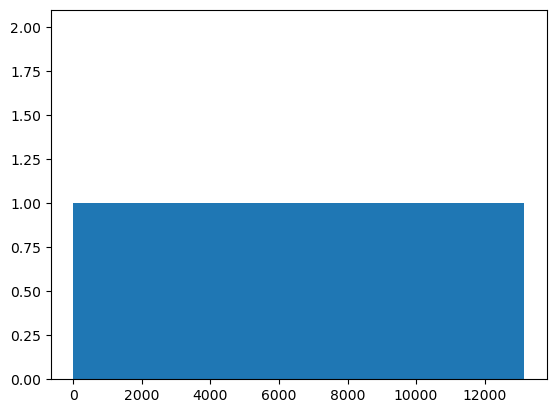

In [ ]:
import matplotlib.pyplot as plt

# Get the indices from the dictionary
indices = list(username_to_index.values())

# Plot a histogram of the indices
plt.hist(indices, bins=range(min(indices), max(indices) + 1))
plt.show()

In [ ]:
print(len(username_to_index))

13154


In [ ]:
user_features.shape[0]

13154

In [ ]:
news_features.shape[0]

186

In [ ]:
news_features.shape[0] + user_features.shape[0]

13340

In [ ]:
# Pad user features with zeros to match number of news features
num_features = max(user_features.shape[1], news_features.shape[1])
if (user_features.shape[1] < num_features):
  padding = np.zeros((user_features.shape[0], num_features - user_features.shape[1]))
  user_features = np.hstack((user_features, padding))

In [ ]:
user_features.shape[1]

138

In [ ]:
news_features.shape[1]

138

In [ ]:
# Combine user and news features
node_attributes = np.vstack((user_features, news_features))

In [ ]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [ ]:
# Save node attributes to .npy file
np.save(f'{path_to_processed_dataset_folder}/node_attributes.npy', node_attributes)

In [9]:
# Read the relationship file into a DataFrame
relationship_df = pd.read_csv(f'{path_to_processed_dataset_folder}/relationship_user_and_news_v2.csv')

# Remove duplicates based on the username
relationship_df = relationship_df.drop_duplicates(subset=['username'])

In [10]:
relationship_df

,username,filename,label,human_evaluation
0,JcKatherine,politifact13816,0.0,4
1,bjr1961,politifact13816,0.0,4
2,SherryAva,politifact13816,0.0,4
3,linnflux,politifact13816,0.0,4
4,po_murray,politifact13816,0.0,4
...,...,...,...,...
14530,Omwenga,politifact12721,1.0,3
14531,MarkPaleo,politifact12721,1.0,3
14532,einerdrake,politifact12721,1.0,4
14533,Corinne4Hillary,politifact12721,1.0,5


In [ ]:

# Create a dictionary mapping usernames to 0
username_labels = {username:  2 for username in relationship_df['username'].unique()}

# Group by the newsname and calculate the associated value
newsname_labels = relationship_df.groupby('filename')['label'].first().to_dict()

# Combine the two dictionaries into a single dictionary
labels = {**username_labels, **newsname_labels}

# Concatenate the usernames and newsnames arrays
nodes = np.concatenate((usernames, newsnames))

# Create a list of labels by looking up each node in the labels dictionary
labels_list = [labels[node] for node in nodes]

print(labels_list)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
len(labels_list)

13340

In [ ]:
# Convert the list of labels to a NumPy array
labels_array = np.array(labels_list)

# Save the array of labels to a .npy file
np.save(f'{path_to_processed_dataset_folder}/labels_v2.npy', labels_array)

In [11]:
# Create adjacency matrix

#calculates the total number of nodes in the graph, which is the sum of the number of users (len(usernames)) and the number of news items (len(newsnames)).
num_nodes = len(usernames) + len(newsnames)

"""
initializes an adjacency matrix as a 2D NumPy array of zeros with shape (num_nodes, num_nodes).
This creates a square matrix with dimensions equal to the total number of nodes in the graph.
The matrix is initially filled with zeros, indicating that there are no edges between any pair of nodes.
"""

adjacency_matrix = np.zeros((num_nodes, num_nodes))

"""
iterates over the rows of the relationship_df DataFrame, which contains the relationships between users 
and news items. For each row, it gets the indices of the user and the news item in the username_to_index and newsname_to_index 
dictionaries, respectively. These indices correspond to the positions of the user and the news item in the adjacency matrix.
Finally, it sets the element of the adjacency matrix at the position (user_id, news_id) to 1, indicating that there is 
an edge between the user and the news item. This is done for every row in the relationship_df DataFrame, effectively filling 
in the adjacency matrix with the relationships between users and news items.
At the end of this code block, adjacency_matrix is a 2D NumPy array that represents the graph of users and news items. If there 
is a relationship between a user and a news item, the corresponding element in the adjacency matrix is 1; otherwise, it is 0.
"""

for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    adjacency_matrix[user_id, news_id] = 1



In [ ]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# Initialize the edge attribute matrix with zeros
edge_attr_matrix = np.zeros((num_nodes, num_nodes))

# Fill the edge attribute matrix with human survey values
for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    survey_value = row['human_evaluation'] 
    edge_attr_matrix[user_id, news_id] = survey_value

# Convert the edge attribute matrix into a tensor
edge_attr_matrix = np.eye(num_nodes) + edge_attr_matrix  # Add self-loops
edge_attr = torch.tensor(edge_attr_matrix[edge_attr_matrix.nonzero()], dtype=torch.float)

In [ ]:
np.save(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', adjacency_matrix)

In [ ]:
edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)

In [ ]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     1,     2,  ..., 13151, 13152, 13153],
        [13202, 13202, 13202,  ..., 13175, 13175, 13175]])
2
13154


In [13]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [14]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [15]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, None)

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y)

/tmp/ipykernel_30803/949867437.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)


In [16]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     0,     1,  ..., 13337, 13338, 13339],
        [    0, 13202,     1,  ..., 13337, 13338, 13339]])
2
26494


In [17]:
print(edge_attr.shape[0])

26494


In [18]:
y.shape

torch.Size([13340])

In [19]:
y.size

<function Tensor.size>

In [20]:
x.size(1)

138

In [21]:
edge_index.shape

torch.Size([2, 26494])

In [22]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=42)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [23]:
print(y)

[2 2 2 ... 1 1 1]


In [24]:
from torch_geometric.nn import MessagePassing
class CustomConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        # edge_attr has shape [E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Multiply edge attributes with edge messages
        edge_attr = edge_attr.view(-1, 1)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j has shape [E, out_channels]
        # edge_attr has shape [E]

        # Step 4: Multiply node features with edge attributes.
        return edge_attr * x_j

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomConv(num_features, 128)
        self.conv2 = CustomConv(128, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)

        return F.log_softmax(x, dim=-1)

In [25]:
# class GCN(torch.nn.Module):
#     def __init__(self, num_features, num_classes):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(num_features, 128)
#         self.conv2 = GCNConv(128, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         #x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=-1)

In [26]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [27]:

model = GCN(num_features=x.size(1), num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
# # loss function optimization considering the weight distribution  

# from torch import device

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     weights = torch.tensor([200.0, 200.0, 0.1]).to(device)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=weights)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# def test(mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(data)
#         preds = logits.max(dim=1)[1]
#         correct = preds[mask].eq(data.y[mask]).sum().item()
#         acc = correct / mask.sum().item()
#         return acc, preds[mask], data.y[mask]


In [29]:
# loss function optimization considering the only two classes 

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    # Create a mask for the fake and real news
    news_mask = (data.y[data.train_mask] == 0) | (data.y[data.train_mask] == 1)
    
    # Apply the mask to the output and labels
    out_news = out[data.train_mask][news_mask]
    labels_news = data.y[data.train_mask][news_mask]
    
    # Compute the loss only for the fake and real news
    loss = F.nll_loss(out_news, labels_news)
    
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]
        
        # Create a mask for the fake and real news
        news_mask = (data.y[mask] == 0) | (data.y[mask] == 1)
        
        # Apply the mask to the predictions and labels
        preds_news = preds[mask][news_mask]
        labels_news = data.y[mask][news_mask]
        
        correct = preds_news.eq(labels_news).sum().item()
        acc = correct / news_mask.sum().item()
        return acc, preds_news, labels_news


In [30]:
# # General training appraoch

# for epoch in range(1, 150):
#     loss = train()
#     train_acc, _, _ = test(data.train_mask)
#     val_acc, _, _ = test(data.val_mask)
#     test_acc, preds, labels = test(data.test_mask)
#     print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

In [31]:
# Best accuracy from epochs

best_acc = 0.0
best_epoch = 0
best_state_dict = None
patience = 100  # Number of epochs to wait for improvement before stopping
wait = 0

for epoch in range(1, 500):
    loss = train()
    train_acc, _, _ = test(data.train_mask)
    val_acc, _, _ = test(data.val_mask)
    test_acc, preds, labels = test(data.test_mask)
    
    # Save the model parameters if this epoch has the best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        wait = 0  # Reset the counter
    else:
        wait += 1  # Increment the counter if no improvement
    
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Stop training if no improvement for 'patience' epochs
    if wait >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Best Val Acc: {best_acc} at Epoch: {best_epoch}')

/home/shoaib/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11030). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1, Loss: 2037457.6250, Train Acc: 0.5000, Val Acc: 0.5510, Test Acc: 0.3684
Epoch: 2, Loss: 1474258.7500, Train Acc: 0.5000, Val Acc: 0.5510, Test Acc: 0.3684
Epoch: 3, Loss: 911547.0000, Train Acc: 0.6000, Val Acc: 0.5986, Test Acc: 0.4737
Epoch: 4, Loss: 439182.3125, Train Acc: 0.7000, Val Acc: 0.7211, Test Acc: 0.6316
Epoch: 5, Loss: 132881.0312, Train Acc: 0.7500, Val Acc: 0.7619, Test Acc: 0.7368
Epoch: 6, Loss: 43133.4688, Train Acc: 0.5000, Val Acc: 0.4558, Test Acc: 0.6316
Epoch: 7, Loss: 254411.6562, Train Acc: 0.5000, Val Acc: 0.4558, Test Acc: 0.6316
Epoch: 8, Loss: 375539.3750, Train Acc: 0.5000, Val Acc: 0.4558, Test Acc: 0.6316
Epoch: 9, Loss: 400659.4062, Train Acc: 0.5000, Val Acc: 0.4558, Test Acc: 0.6316
Epoch: 10, Loss: 356305.2500, Train Acc: 0.5000, Val Acc: 0.4558, Test Acc: 0.6316
Epoch: 11, Loss: 259532.2812, Train Acc: 0.6000, Val Acc: 0.4966, Test Acc: 0.6316
Epoch: 12, Loss: 123019.9141, Train Acc: 0.8000, Val Acc: 0.7959, Test Acc: 0.6842
Epoch: 13, L

In [32]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'gcn_model_human_evaluation_128'
path = f'{path_to_saved_model_folder}/{model_name}.pth'

torch.save(best_state_dict, path)

Fold 1 Test Accuracy: 0.7567567567567568
Fold 1 Test F1 Score: 0.7463187325256291
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        19
           1       0.91      0.56      0.69        18

    accuracy                           0.76        37
   macro avg       0.80      0.75      0.74        37
weighted avg       0.80      0.76      0.75        37



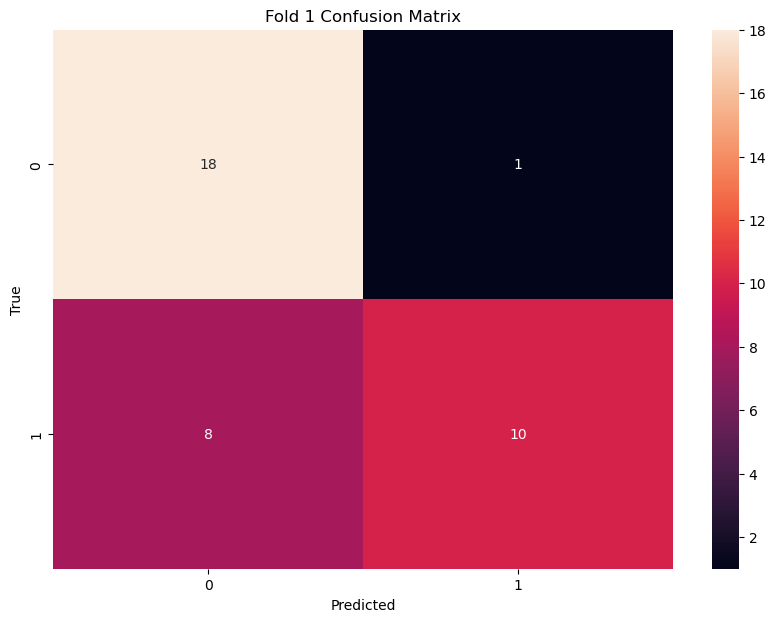

Fold 2 Test Accuracy: 0.7567567567567568
Fold 2 Test F1 Score: 0.7512824151983942
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        19
           1       0.85      0.61      0.71        18

    accuracy                           0.76        37
   macro avg       0.78      0.75      0.75        37
weighted avg       0.78      0.76      0.75        37



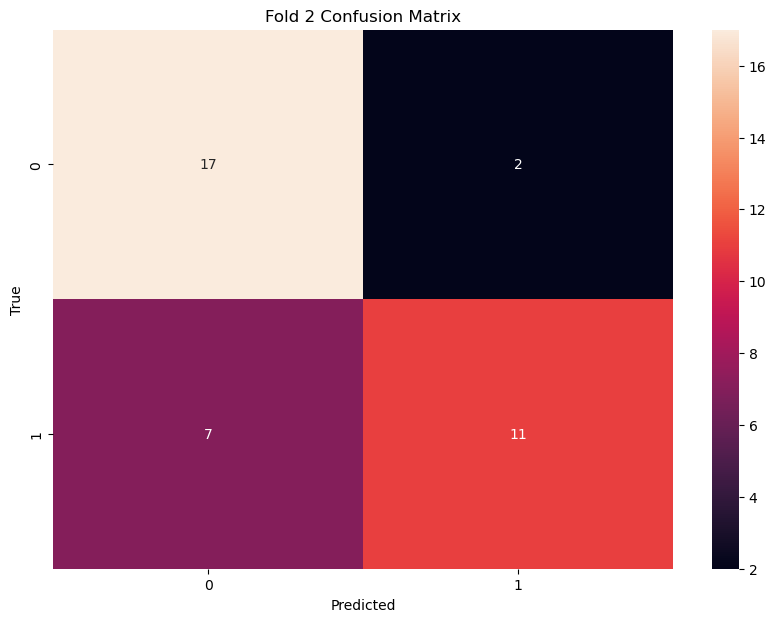

Fold 3 Test Accuracy: 0.7837837837837838
Fold 3 Test F1 Score: 0.7837837837837838
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.78      0.78      0.78        18

    accuracy                           0.78        37
   macro avg       0.78      0.78      0.78        37
weighted avg       0.78      0.78      0.78        37



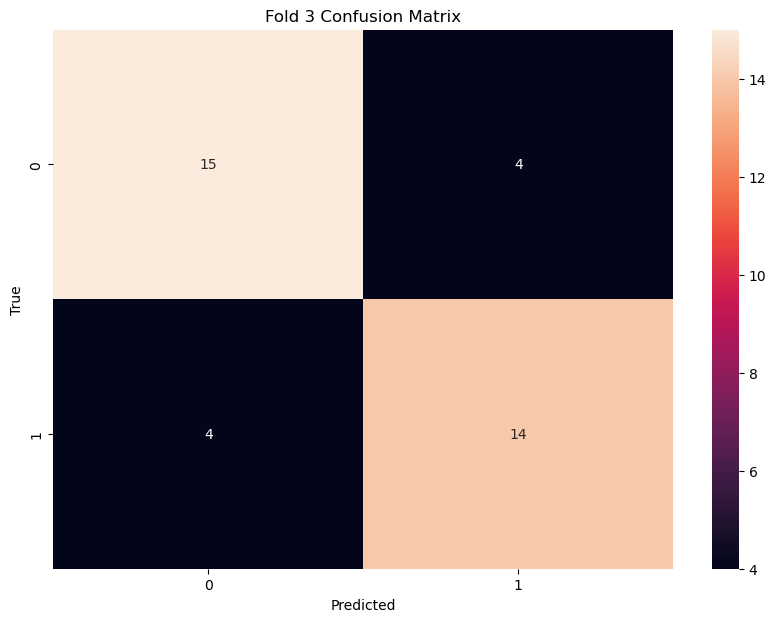

Fold 4 Test Accuracy: 0.8918918918918919
Fold 4 Test F1 Score: 0.8910875160875161
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.93      0.82      0.87        17

    accuracy                           0.89        37
   macro avg       0.90      0.89      0.89        37
weighted avg       0.90      0.89      0.89        37



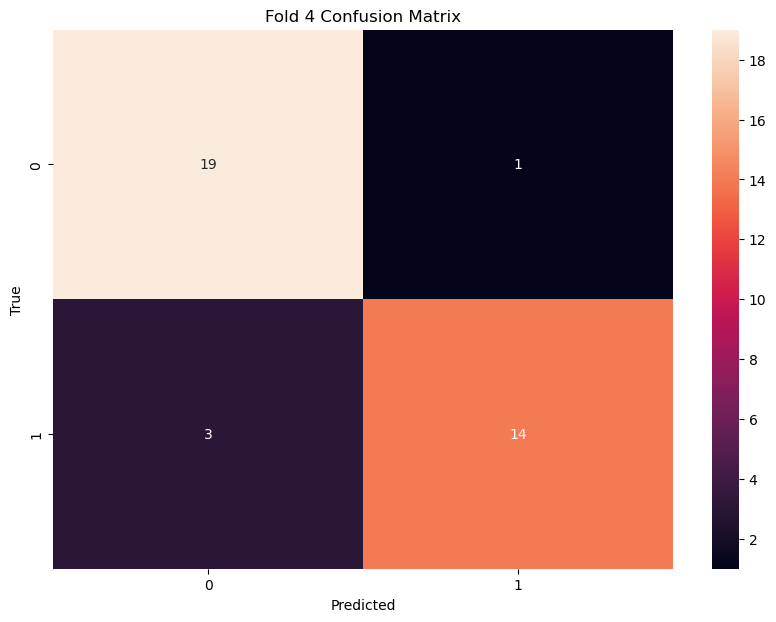

Fold 5 Test Accuracy: 0.7631578947368421
Fold 5 Test F1 Score: 0.7522106807738349
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        20
           1       0.91      0.56      0.69        18

    accuracy                           0.76        38
   macro avg       0.81      0.75      0.75        38
weighted avg       0.80      0.76      0.75        38



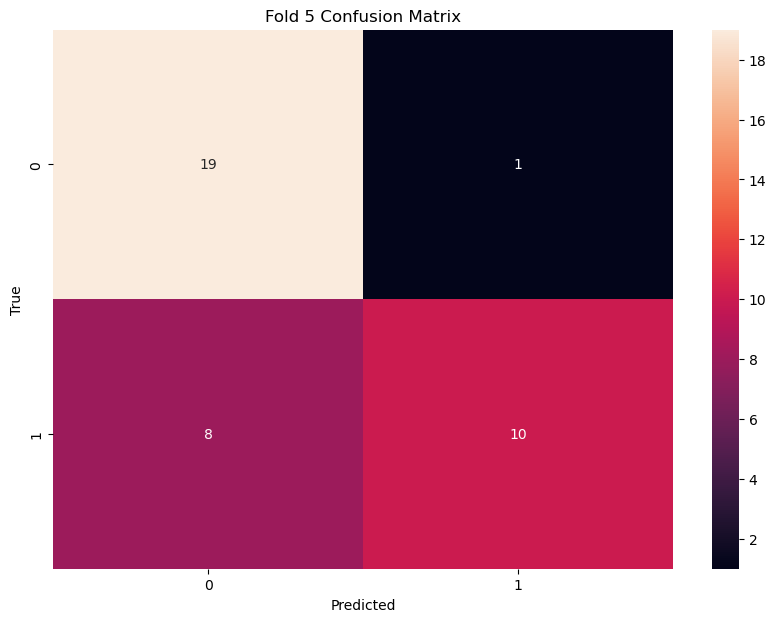

Average Test Accuracy: 0.7904694167852063
Average Test F1 Score: 0.7849366256738316


In [33]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store the accuracy and F1 score for each fold
accuracy_scores = []
f1_scores = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(cv.split(np.zeros(len(y)), y), start=1):
    # # Split the data into training and test sets
    data.train_mask = index_to_mask(torch.tensor(train_index), size=num_nodes)
    data.test_mask = index_to_mask(torch.tensor(test_index), size=num_nodes)

    # Load the best model
    model.load_state_dict(torch.load(path))

    # predictions with the best model
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]

    # Create a mask for the fake and real news
    news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

    # Apply the mask to the labels and predictions
    labels_news = data.y[news_mask]
    preds_news = preds[news_mask]

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
    f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

    # Store the accuracy and F1 score
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f'Fold {i} Test Accuracy: {accuracy}')
    print(f'Fold {i} Test F1 Score: {f1}')

    report = classification_report(labels_news.cpu(), preds_news.cpu())
    print(f'Fold {i} Classification Report:')
    print(report)

    cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {i} Confusion Matrix')
    plt.show()

# Compute the average accuracy and F1 score
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Test Accuracy: {average_accuracy}')
print(f'Average Test F1 Score: {average_f1}')

In [34]:
# # After training, calculate additional metrics on the test set
# accuracy = accuracy_score(labels, preds)
# f1 = f1_score(labels, preds, average='weighted')  # Use 'weighted' for multi-class problems

# print(f'Final Test Accuracy: {accuracy}')
# print(f'Final Test F1 Score: {f1}')

# report = classification_report(labels, preds)
# print(report)
# # Create a confusion matrix
# cm = confusion_matrix(labels, preds)

# # Plot the confusion matrix as a heatmap
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()